# Language Identification using FastText

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/1337-Artificial-Intelligence/hackai-2025/blob/main/new_notebooks/data_language_identification_fasttext.ipynb)

**Time Estimate**: 1 hour

## Learning Objectives
- Understand what language identification is and why it's important
- Learn how to use FastText for text classification
- Build a simple model to identify Moroccan Darija vs other Arabic dialects

*"Is this text written in Moroccan Darija or another arabic dialect?"*

This notebook demonstrates language identification of Darija among other arabic dialects using FastText. This task is important for many applications, specifically for data quality filtering.

The dataset used is AtlasIA's Darija-LID dataset [https://huggingface.co/datasets/atlasia/Darija-LID](https://huggingface.co/datasets/atlasia/Darija-LID).
There is no restriction on the choice of the dataset, you can use any other dataset that can help you achieve the task.

- **Setup**
    - Installs and imports required packages: fasttext, datasets, pandas, scikit-learn, seaborn

- **Data Preparation**
    - Loads and preprocesses text data
    - Exploratory data analysis

- **Model Training & Evaluation**
    - Trains FastText model on prepared data
    - Evaluates model performance

- **Hyperparameter Tuning**
    - Adjusts model parameters for better performance

- **Requirements**
    - Python >= 3.10
    - See pip install commands in notebook for package requirements



# Setup

In [ ]:
! uv pip install fasttext datasets pandas scikit-learn seaborn

# Optional for data visualization
! uv pip install arabic-reshaper wordcloud python-bidi

In [ ]:
import fasttext
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datasets import load_dataset

/fsx/nouamane/projects/transformers/pt27-cu124/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# DO NOT DELETE/HIDE THIS FUNCTION
def validate_fasttext_format(file_path) -> dict:
    """Utility function to validate the format of the data for fasttext"""
    n_errors = 0
    emptylines = []
    labelmissing = []
    spacemissing = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            if not line.strip():
                #print(f"Empty line found at line {i}")
                emptylines.append(i)
                n_errors += 1
                continue
            if not line.startswith('__label__'):
                # print(f"Line {i} doesn't start with __label__: {line[:100]}")
                labelmissing.append(i)
                n_errors += 1
                continue
            if ' ' not in line:
                # print(f"Line {i} has no space after label: {line[:100]}")
                spacemissing.append(i)
                n_errors += 1
                continue
    errors_report = {
        'empty line': emptylines,
        '__label__ missing': labelmissing,
        'whitespace missing': spacemissing
        }
    print(f"Data format validation complete. Found {n_errors} errors.")
    return errors_report


# Load and explore data

In [ ]:
# Load data from AtlasIA -- You can change the dataset if you want
data = load_dataset('atlasia/Darija-LID')

train_data = data['train']
test_data = data['test']

train_data = train_data.to_pandas()
test_data = test_data.to_pandas()

#### Preprocessing

In [ ]:
def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # remove Latin characters but keep Arabic text
    text = re.sub(r'[a-zA-Z]', '', text)
    # remove emojis but keep Arabic text
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = text.lower()
    return text

train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

#### Distribution of Number of Words in train data

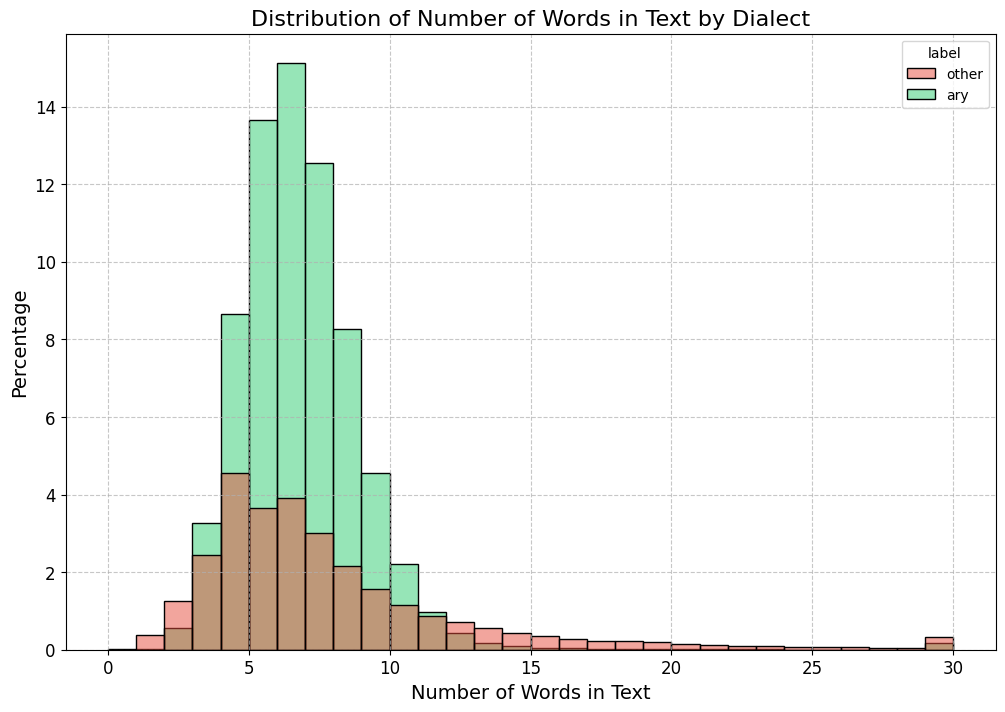

In [ ]:
palette = {'ary': '#2ecc71', 'other': '#e74c3c'}

# recalculate text length
train_data['text_length'] = train_data['processed_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 8))
sns.histplot(
    data=train_data.assign(text_length_clipped=train_data['text_length'].clip(upper=30)),
    x='text_length_clipped',
    hue='label',
    bins=30,
    palette=palette,
    multiple="layer",
    stat='percent'
)
plt.title('Distribution of Number of Words in Text by Dialect', fontsize=16)
plt.xlabel('Number of Words in Text', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


#### Most common words in Ary vs Other dialects (train data)

In [ ]:
train_data

,label,processed_text
1092,__label__other,وين الفرفشة اللي شفناها الصبح
95621,__label__ary,راه الدنيا تبدلات حتى الخبار مبقاش مضمون
173033,__label__ary,الله ي عاون العلماء باش ي لقاو الدواء ديال الس...
67315,__label__ary,الوزير دار خرجة اعلامية جديدة ما فهمنا منها والو
13747,__label__other,وفي عندي فيديو بالإشي هذا
...,...,...
53459,__label__ary,راك عارف الزمان صعيب الخدمة ولات قليلة
10742,__label__other,بسم الله على الخيول تجوب أرضكم وعلى كعابها إن ...
49689,__label__ary,ياك سمعتي هاد الأسبوع عيد الأضحى
189636,__label__ary,النهار اليوم كيشهي نطلعو نتغداو فالسطح


--2025-05-18 21:20:31--  https://raw.githubusercontent.com/google/fonts/main/ofl/amiri/Amiri-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452544 (442K) [application/octet-stream]
Saving to: ‘Amiri-Regular.ttf.1’

Amiri-Regular.ttf.1 100%[===================>] 441.94K  --.-KB/s    in 0.009s  

2025-05-18 21:20:31 (48.3 MB/s) - ‘Amiri-Regular.ttf.1’ saved [452544/452544]



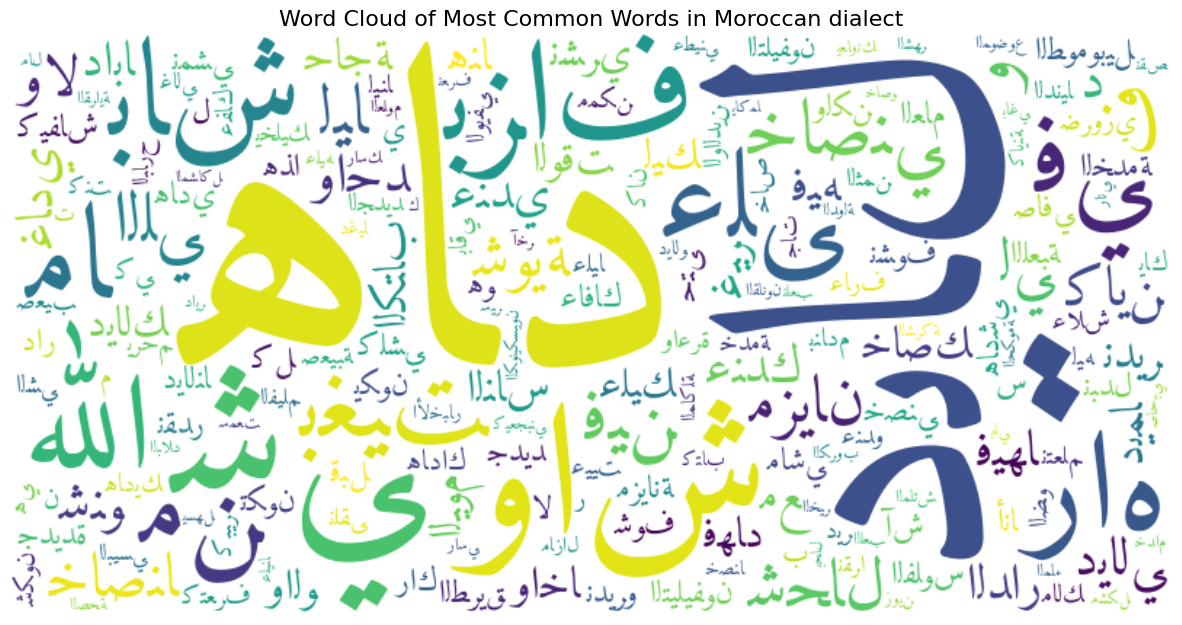

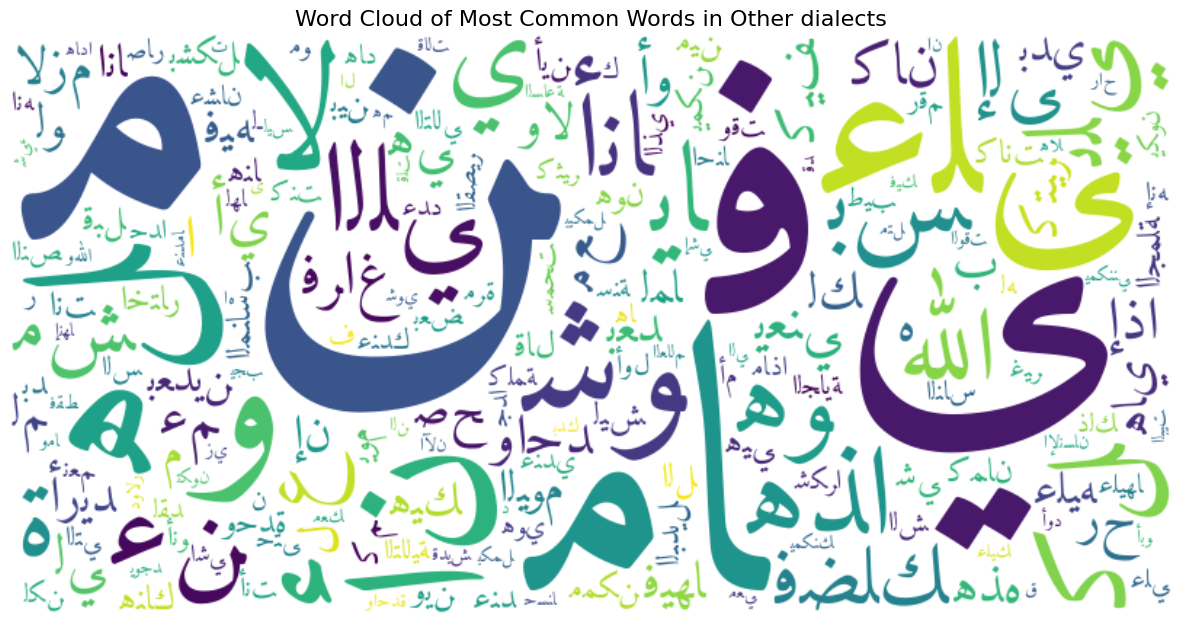

In [ ]:
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter
from heapq import nlargest
from wordcloud import WordCloud

# if you don't have this font, you can download it https://raw.githubusercontent.com/google/fonts/main/ofl/amiri/Amiri-Regular.ttf
# !wget https://raw.githubusercontent.com/google/fonts/main/ofl/amiri/Amiri-Regular.ttf
font_path = 'Amiri-Regular.ttf'

words_counts_ary = Counter(' '.join(train_data[train_data['label'].str.contains('ary')]['processed_text']).split())
words_counts_other = Counter(' '.join(train_data[train_data['label'].str.contains('other')]['processed_text']).split())

# Function to preprocess Arabic text
def preprocess_arabic_words(word_freq):
    reshaped_word_freq = {}
    for word, freq in word_freq.items():
        # Reshape and reorder the Arabic word
        reshaped_word = arabic_reshaper.reshape(word)
        bidi_word = get_display(reshaped_word)
        reshaped_word_freq[bidi_word] = freq
    return reshaped_word_freq


# ------------------top 1k words in Ary------------------------------------
top_word_counts = dict(nlargest(1000, words_counts_ary.items(), key=lambda x: x[1]))
reshaped_word_counts = preprocess_arabic_words(top_word_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path
).generate_from_frequencies(reshaped_word_counts)

# plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Moroccan dialect', fontsize=16)
plt.show()


# ------------------top 1k words in Other------------------------------------
top_word_counts = dict(nlargest(1000, words_counts_other.items(), key=lambda x: x[1]))
reshaped_word_counts = preprocess_arabic_words(top_word_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path
).generate_from_frequencies(reshaped_word_counts)

# plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Other dialects', fontsize=16)
plt.show()


# Train (binary)

In [ ]:
# data should have a specific format for fasstext
data_train = train_data[['label', 'processed_text']].copy()
data_train['label'] = '__label__' + data_train['label']

data_test = test_data[['label', 'processed_text']].copy()
data_test['label'] = '__label__' + data_test['label']

# save
data_train.to_csv('data_train.txt', header=None, index=None, sep=' ', mode='w')
data_test.to_csv('data_test.txt', header=None, index=None, sep=' ', mode='w')

In [ ]:
# Validate the data
print("\nTrain Data")
_ = validate_fasttext_format('data_train.txt') # you can get the report of errors if there are any
print("\nTest Data")
_ = validate_fasttext_format('data_test.txt') # you can get the report of errors if there are any


Train Data
Data format validation complete. Found 0 errors.

Test Data
Data format validation complete. Found 0 errors.


In [ ]:

training_params = {
    "lr": 0.1,
    "epoch": 5,
    "dim": 100,
    "minCount": 5,
    "wordNgrams": 5,
    "bucket": 200,
    "loss": "softmax",
}

model = fasttext.train_supervised('data_train.txt', **training_params)


Read 2M words
Number of words:  24236
Number of labels: 2
Progress: 100.0% words/sec/thread:   92074 lr:  0.000000 avg.loss:  0.133617 ETA:   0h 0m 0s


# Evaluate

In [ ]:
with open('data_test.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

samples = list(map(lambda x:x.replace('\n', ''), lines))
texts = [' '.join(x.split()[1:]) for x in lines]
preds = model.predict(texts)

# get __label__ from preds
y_hat = [x[0].split('__label__')[1] for x in preds[0]]
# get __label__ from lines
y_true = [x.split('__label__')[1].split()[0] for x in lines]



Classification Report:
              precision    recall  f1-score   support

         ary       0.99      0.99      0.99     37761
       other       0.98      0.97      0.97     15465

    accuracy                           0.99     53226
   macro avg       0.98      0.98      0.98     53226
weighted avg       0.99      0.99      0.99     53226



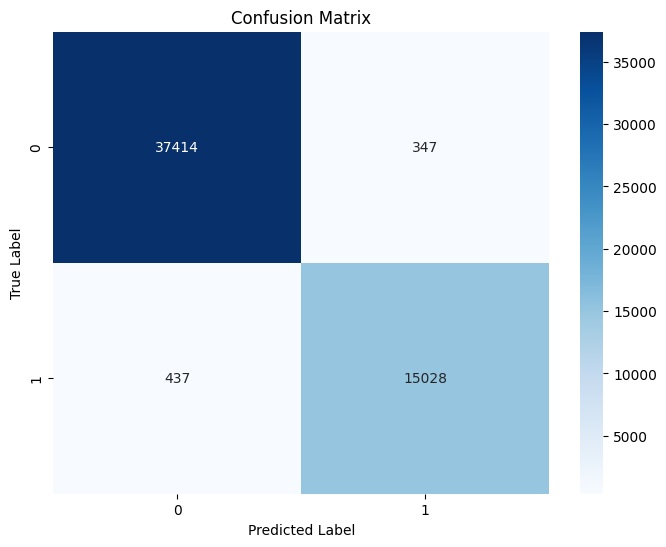

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_true, y_hat)
precision = precision_score(y_true, y_hat, pos_label='ary')
recall = recall_score(y_true, y_hat, pos_label='ary')
f1 = f1_score(y_true, y_hat, pos_label='ary')


print("\nClassification Report:")
print(classification_report(y_true, y_hat))


cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Hyperparameter tuning
- You can use FastText's built-in hyperparameter tuning [https://fasttext.cc/docs/en/autotune.html](https://fasttext.cc/docs/en/autotune.html)
- Or you can use a custom grid search

In [ ]:
# prepare validation data
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data_train, test_size=0.2, random_state=7)

# save validation data
val_data.to_csv('data_val.txt', header=None, index=None, sep=' ', mode='w')

Progress:   7.7% Trials:   19 Best score:  1.000000 ETA:   0h 4m36s
Aborting autotune...
Progress:   7.8% Trials:   19 Best score:  1.000000 ETA:   0h 4m36s
Training again with best arguments
Read 2M words
Number of words:  129090
Number of labels: 2
Progress: 100.0% words/sec/thread:  182251 lr:  0.000000 avg.loss:  0.038716 ETA:   0h 0m 0s100.0% words/sec/thread:  182714 lr: -0.000053 avg.loss:  0.038716 ETA:   0h 0m 0s


              precision    recall  f1-score   support

         ary       0.99      0.99      0.99     37761
       other       0.98      0.98      0.98     15465

    accuracy                           0.99     53226
   macro avg       0.98      0.99      0.98     53226
weighted avg       0.99      0.99      0.99     53226



Text(0.5, 36.72222222222221, 'Predicted Label')

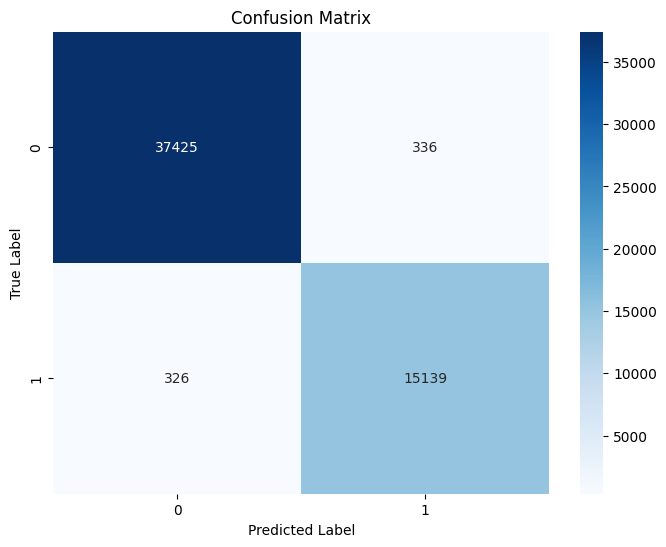

In [ ]:
# You can use FastText's built-in hyperparameter tuning
model = fasttext.train_supervised('data_train.txt', autotuneValidationFile='data_val.txt')

# Evaluate
with open('data_test.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

samples = list(map(lambda x:x.replace('\n', ''), lines))
texts = [' '.join(x.split()[1:]) for x in lines]
preds = model.predict(texts)

# get __label__ from preds
y_hat = [x[0].split('__label__')[1] for x in preds[0]]
# get __label__ from lines
y_true = [x.split('__label__')[1].split()[0] for x in lines]

print(classification_report(y_true, y_hat))


cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')



In [ ]:
# Or you can use a custom grid search
best_accuracy = 0
best_params = {}

for lr in [0.01, 0.05, 0.1, 0.2]:
    for epoch in [3, 5, 10]:
        for dim in [50, 100, 200]:
            for minCount in [1, 5, 10]:
                for wordNgrams in [1, 2, 3]:
                    for bucket in [100, 200, 300]:
                        for loss in ['softmax', 'ova']:
                            training_params = {
                                "lr": lr,
                                "epoch": epoch,
                                "dim": dim,
                                "minCount": minCount,
                                "wordNgrams": wordNgrams,
                                "bucket": bucket,
                                "loss": loss
                            }
                            model = fasttext.train_supervised('data_train.txt', **training_params)
                            # Evaluate
                            with open('data_test.txt', 'r', encoding='utf-8') as f:
                                lines = f.readlines()

                            samples = list(map(lambda x:x.replace('\n', ''), lines))
                            texts = [' '.join(x.split()[1:]) for x in lines]
                            preds = model.predict(texts)

                            # get __label__ from preds
                            y_hat = [x[0].split('__label__')[1] for x in preds[0]]
                            # get __label__ from lines
                            y_true = [x.split('__label__')[1].split()[0] for x in lines]

                            print(classification_report(y_true, y_hat))

                            accuracy = accuracy_score(y_true, y_hat)
                            if accuracy > best_accuracy:
                                best_accuracy = accuracy
                                best_params = training_params

print(f"Best accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")


# Optional: Submit your model to AtlasIA's Darija LID leaderboard

- Go to [https://huggingface.co/spaces/atlasia/DarijaLID-Leaderboard](https://huggingface.co/spaces/atlasia/DarijaLID-Leaderboard)
- Submit your model / model_id (if stored in HF !! it should be public) / predictions (if using another architecture)

# Bonus Questions
- For this task, what is the most important metric to optimize?
- Can you think of another architecture that can be used to achieve this task?
- How can you improve the performance of the model?

# Next Steps
- Try different preprocessing steps
- Experiment with different FastText parameters
- Try the model on different Arabic dialects
- Learn about other text classification methods